In [2]:
"""
Description: This code uses an Artificial RNN (LSTM: Long Short Term Memory Architecture) to predict the
closing cryptocurrency price.
We use RNN as we are processing a sequence of data, and not standalone data points.
"""
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf
import sklearn
import keras
import tensorflow
plt.style.use("fivethirtyeight")

In [3]:
tensorflow.__version__

'2.13.0'

In [4]:
df = pd.read_csv("cryptocurrencies_combined_daily.csv")
df = df[df['Cryptocurrency'] == "Bitcoin"]
df

,Date,Open,High,Low,Close,Adj Close,Volume,Cryptocurrency
0,2019-08-15,10038.421875,10437.411133,9675.316406,10311.545898,10311.545898,22899115082,Bitcoin
1,2019-08-16,10319.419922,10524.349609,9855.478516,10374.338867,10374.338867,20228207096,Bitcoin
2,2019-08-17,10358.722656,10452.625000,10086.698242,10231.744141,10231.744141,13778035685,Bitcoin
3,2019-08-18,10233.005859,10487.070312,10119.094727,10345.810547,10345.810547,12999813869,Bitcoin
4,2019-08-19,10350.283203,10916.053711,10313.204102,10916.053711,10916.053711,16038264603,Bitcoin
...,...,...,...,...,...,...,...,...
1822,2024-08-10,60881.230469,61464.511719,60287.566406,60945.812500,60945.812500,15745822278,Bitcoin
1823,2024-08-11,60944.890625,61778.660156,58348.824219,58719.484375,58719.484375,22759754812,Bitcoin
1824,2024-08-12,58719.394531,60680.332031,57688.898438,59354.515625,59354.515625,37078637820,Bitcoin
1825,2024-08-13,59356.207031,61572.398438,58506.253906,60609.566406,60609.566406,30327698167,Bitcoin


In [5]:
df.to_csv('Bitcoin_data.csv',index=False)

In [6]:
# Create a new dataframe with only the "Close" column.
data = df.filter(["Close"])
dataset = data.values

training_data_len = int(math.ceil(0.75 * len(dataset))) # Calculates the number of training examples, which is 75% of the total data points. The remaining 25% is reserved for testing/validation.

# Data preprocessing
scaler = MinMaxScaler(feature_range=(0, 1)) # Scales the closing prices to a range between 0 and 1. This normalization ensures that the model performs better and converges faster during training.
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.07841059],
       [0.07933249],
       [0.07723898],
       ...,
       [0.79843727],
       [0.81686335],
       [0.78937514]])

In [7]:
"""
Training the model.x_train: Contains sequences of 90 past closing prices (a window of 90 days).
y_train: Contains the next closing price corresponding to each sequence in x_train.
The for-loop constructs this sequential dataset by sliding a 90-day window over the training data.
"""

train_data = scaled_data[:training_data_len, :]
# Split the data into x_train and y_train dataset.
x_train, y_train = [], []
d = 90
# Append the past 90 day values.
for i in range(d, len(train_data)):
    x_train.append(train_data[i - d:i, 0])
    y_train.append(train_data[i, 0])
"""
x_train array contains the past 90 days value of the closing price.
y_train contains the 91st value that we want our model to be able to predict based on those
past 90 day closing prices.
"""
print(x_train[0])
print(y_train[0])

[0.07841059 0.07933249 0.07723898 0.07891365 0.0872857  0.08504205
 0.0758634  0.07576071 0.07982617 0.07618509 0.07587026 0.07928083
 0.07656004 0.07023116 0.06664559 0.06793718 0.06841419 0.07028325
 0.0789276  0.08299115 0.08256469 0.08228633 0.07902364 0.08143071
 0.08031523 0.07875456 0.07553931 0.07645539 0.07985791 0.07913
 0.07909332 0.07894158 0.07790038 0.07737887 0.0767472  0.077748
 0.07650339 0.07412609 0.07487008 0.06986267 0.05358439 0.05162333
 0.04622015 0.048171   0.04808393 0.04600312 0.04878796 0.04951335
 0.05024398 0.04829061 0.04749703 0.04669778 0.04429963 0.04807964
 0.04783241 0.05321991 0.05308386 0.04919741 0.04941468 0.04918638
 0.0499745  0.04748865 0.04517129 0.04599909 0.04408016 0.04430557
 0.04773397 0.04805171 0.04562166 0.03734815 0.03703715 0.05417362
 0.06275164 0.06725509 0.06291572 0.06543418 0.06217545 0.06208528
 0.06298848 0.06392242 0.06261043 0.06521285 0.0641839  0.06445334
 0.06308328 0.05629041 0.05641816 0.05997028 0.05559902 0.0564487 ]

In [8]:
# Convert the x_train and y_train dataset to NumPy arrays to prepare for feeding into the LSTM model.
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the x_train dataset.
"""
LSTM Network expects the data to be 3-D: Number of samples, timestamps, features.LSTM models expect the input data to be 3-dimensional: (number of samples, time steps, features). In this case:
Number of samples = the number of 90-day sequences.
Time steps = 90 (the number of days in each sequence).
Features = 1 (the closing price is the only feature).
"""
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [9]:
"""LSTM Layers:
Multiple LSTM layers are used with decreasing numbers of neurons (125, 100, 70, 50, and 30). The first four layers have return_sequences=True, which means each LSTM layer outputs the entire sequence for the next layer to process.
The final LSTM layer outputs only the last prediction (return_sequences=False).
Dense Layers:
Two fully connected (dense) layers are added after the LSTM layers: one with 25 neurons and the output layer with 1 neuron (the predicted price)."""


model = Sequential()


model.add(LSTM(125, return_sequences=True, input_shape=(x_train.shape[1], 1)))

model.add(LSTM(100, return_sequences=True))
model.add(LSTM(70, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(30, return_sequences=False))

model.add(Dense(25))
model.add(Dense(1))

In [10]:
# Compile the model.
model.compile(optimizer="adam", loss="mean_absolute_error")
# Train the model.
"""
No. of forward and backward passes for backpropagation algorithm = 1.
Batch size = 1.
optimizer="adam": Uses the Adam optimizer for efficient gradient-based optimization.
loss="mean_absolute_error": The model is trained to minimize the Mean Absolute Error (MAE), which measures the average magnitude of errors in predictions.
batch_size=5: The model updates weights after processing every 5 data points.
epochs=5: The model passes over the entire training dataset 5 times.
"""
model.fit(x_train, y_train, batch_size=5, epochs=5)

Epoch 1/5
257/257 [==============================] - 27s 81ms/step - loss: 0.0614
Epoch 2/5
257/257 [==============================] - 21s 81ms/step - loss: 0.0403
Epoch 3/5
257/257 [==============================] - 21s 81ms/step - loss: 0.0326
Epoch 4/5
257/257 [==============================] - 21s 82ms/step - loss: 0.0277
Epoch 5/5
257/257 [==============================] - 21s 82ms/step - loss: 0.0230


In [11]:
"""test_data: Contains the scaled closing prices from the last 90 days of training data to the end of the dataset.
x_test: Created similarly to x_train, but using the test data, each sequence contains 90 previous closing prices.
y_test: Contains the actual closing prices for validation."""

# Create the testing dataset.
test_data = scaled_data[training_data_len - 90:, :]
# Create the datasets x_test and y_test.
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(90, len(test_data)):
    x_test.append(test_data[i - 90:i, 0])

In [12]:
# Convert the data to a NumPy array.
x_test = np.array(x_test)
# Reshape the data.
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(456, 90, 1)

In [13]:
"""model.predict(x_test): Generates the predicted closing prices based on the test dataset.
scaler.inverse_transform(predictions): Reverses the scaling to convert predictions back to the original price scale for comparison with actual prices."""
# Get the model's predicted price values.
predictions = model.predict(x_test)
# Unscale the values to compare the predictions.
predictions = scaler.inverse_transform(predictions)

15/15 [==============================] - 2s 40ms/step


In [14]:
# Calculates the Mean Absolute Error (MAE) by averaging the absolute difference between the predicted and actual closing prices.
mae = np.mean(np.abs(predictions - y_test))
mae

1163.614077919408

In [15]:
# Evaluation of the model using RMSE Error as percentage.
mae_percent = np.mean(np.abs(predictions - y_test))*100/np.mean(y_test)
mae_percent

2.551773132887531

In [16]:
import os

if not os.path.exists('static/images/'):
    os.makedirs('static/images/')

C:\Users\uttka\AppData\Local\Temp\ipykernel_26156\2574754052.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


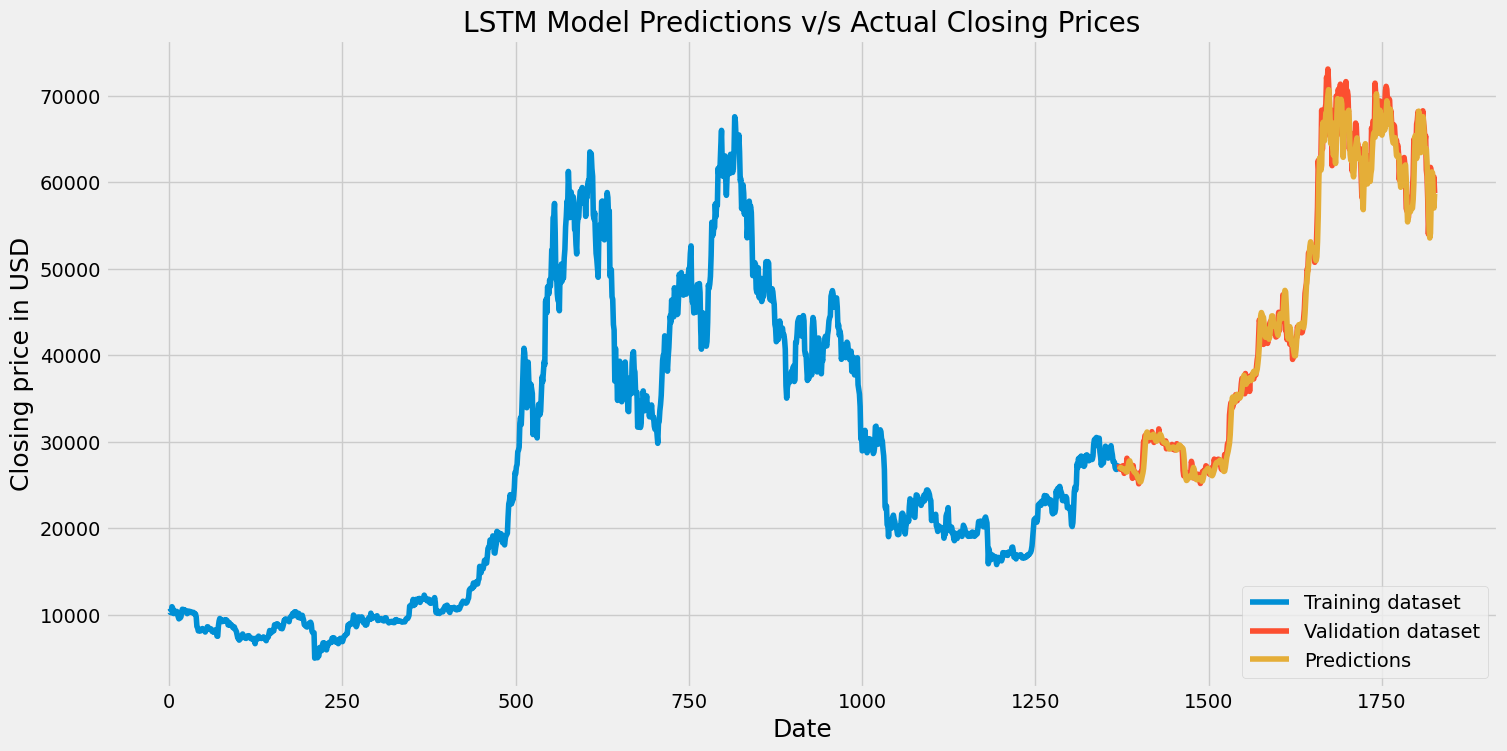

In [17]:
"""Plot the data.train: Contains the training data.
valid: Contains the validation data and the model’s predictions.
Plot: A graph is generated to compare the actual and predicted closing prices."""
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions


plt.figure(figsize=(16, 8))
plt.title("LSTM Model Predictions v/s Actual Closing Prices")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing price in USD", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Training dataset", "Validation dataset", "Predictions"], loc="lower right")
plt.show()
plt.savefig('Bitcoin.png')
plt.close()

In [18]:
valid

,Close,Predictions
1371,27398.802734,26757.044922
1372,26832.208984,26929.546875
1373,26890.128906,27012.541016
1374,27129.585938,26965.910156
1375,26753.826172,26899.437500
...,...,...
1822,60945.812500,61188.890625
1823,58719.484375,61071.175781
1824,59354.515625,58383.523438
1825,60609.566406,57016.273438


In [19]:
valid.to_csv('Bitcoin_pred.csv', index=False)

In [20]:
train_data

array([[0.07841059],
       [0.07933249],
       [0.07723898],
       ...,
       [0.32240458],
       [0.32625195],
       [0.323961  ]])

In [21]:
"""This block of code generates predictions for future prices based on the last known data.
It appends each new prediction to the current sequence and makes further predictions for num_days into the future."""
current_feature = train_data[-d:]
num_days, curr_day = 100, 0
while curr_day < num_days:
    prediction = model.predict(current_feature.reshape(1, d, 1))
    curr_day += 1
    current_feature = np.append(current_feature, prediction)
    prediction = scaler.inverse_transform(prediction)
    current_feature = current_feature[1:]

print(prediction)

1/1 [==============================] - 0s 29ms/step
[[13950.494]]


In [22]:
"""This code is designed to find the optimal value for d—the number of past days used to predict the next closing price in a time series model using an LSTM architecture.
It iterates over a set of different d values (7, 10, 30, 60, 90, 120), trains an LSTM model for each value of d, and evaluates its performance using Mean Absolute Error (MAE). """

d_values = [7, 10, 30, 60, 90, 120]
mae_values = []
"""The for-loop iterates over each value of d in d_values, and for each iteration,
a complete model is built, trained, and evaluated."""
for d in d_values:
    
    df = pd.read_csv("cryptocurrencies_combined_daily.csv")
    df = df[df['Cryptocurrency'] == "Bitcoin"]
    
    data = df.filter(["Close"])
   
    dataset = data.values

    
    training_data_len = int(math.ceil(0.75 * len(dataset)))

   
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    """
Training the model.train_data: Contains the scaled training data (the first 75% of the dataset).
x_train: This is where the input sequences are stored. 
For each sequence, it takes d past values from the train_data to predict the next value.
y_train: This stores the value the model is trained to predict—the day after the d past values.
The for-loop moves a sliding window over the training data, creating input-output pairs.
    """
    
    train_data = scaled_data[:training_data_len, :]
  
    x_train, y_train = [], []
    d = 90
    
    for i in range(d, len(train_data)):
        x_train.append(train_data[i - d:i, 0])
        y_train.append(train_data[i, 0])
    """
    x_train array contains the past 90 days value of the closing price of the stock.
    y_train contains the 91st value that we want our model to be able to predict based on those
    past 90 day closing prices.
    """
    
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the x_train dataset.
    """
    LSTM Network expects the data to be 3-D: Number of samples, timestamps, features.
    """
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # Build the LSTM Model Architecture.
    model1 = Sequential()

  
    model1.add(LSTM(125, return_sequences=True, input_shape=(x_train.shape[1], 1)))
   
    model1.add(LSTM(100, return_sequences=True))
    model1.add(LSTM(70, return_sequences=True))
    model1.add(LSTM(50, return_sequences=True))
    model1.add(LSTM(30, return_sequences=False))

   
    model1.add(Dense(25))
    model1.add(Dense(1))

    # Compile the model.
    model1.compile(optimizer="adam", loss="mean_absolute_error")
    # Train the model.
    """
    No. of forward and backward passes for backpropagation algorithm = 1.
    Batch size = 1.
    """
    model1.fit(x_train, y_train, batch_size=5, epochs=5)
   
    test_data = scaled_data[training_data_len - d:, :]
    
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(d, len(test_data)):
        x_test.append(test_data[i - d:i, 0])
    
    x_test = np.array(x_test)
   
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    
    predictions = model1.predict(x_test)
   
    predictions = scaler.inverse_transform(predictions)

    mae = np.mean(np.abs(predictions - y_test))
    mae_values.append(mae)

Epoch 1/5
257/257 [==============================] - 27s 81ms/step - loss: 0.0602
Epoch 2/5
257/257 [==============================] - 21s 81ms/step - loss: 0.0422
Epoch 3/5
257/257 [==============================] - 21s 82ms/step - loss: 0.0344
Epoch 4/5
257/257 [==============================] - 21s 81ms/step - loss: 0.0302
Epoch 5/5
15/15 [==============================] - 2s 42ms/step
Epoch 1/5
257/257 [==============================] - 28s 84ms/step - loss: 0.0546
Epoch 2/5
257/257 [==============================] - 22s 85ms/step - loss: 0.0403
Epoch 3/5
257/257 [==============================] - 22s 86ms/step - loss: 0.0335
Epoch 4/5
257/257 [==============================] - 22s 84ms/step - loss: 0.0276
Epoch 5/5
15/15 [==============================] - 2s 41ms/step
Epoch 1/5
257/257 [==============================] - 28s 82ms/step - loss: 0.0624
Epoch 2/5
257/257 [==============================] - 21s 83ms/step - loss: 0.0405
Epoch 3/5
257/257 [==============================] -

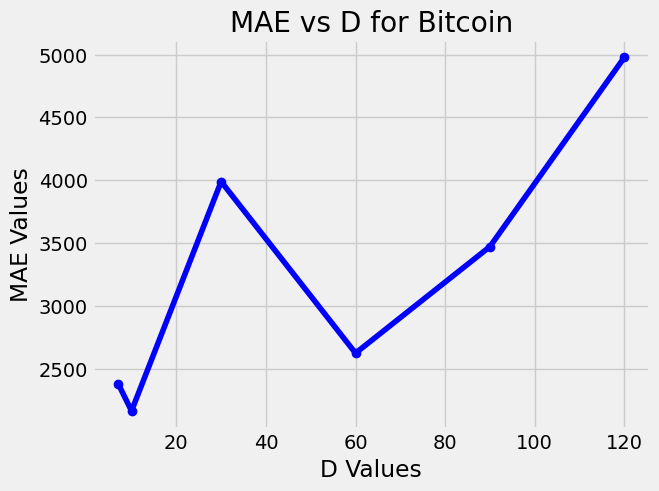

In [23]:
plt.plot(d_values, mae_values, marker='o', linestyle='-', color='b')


plt.title('MAE vs D for Bitcoin')
plt.xlabel('D Values')
plt.ylabel('MAE Values')


plt.grid(True)


plt.show()

In [24]:
with open('Bitcoin.pkl','wb') as file:
    pickle.dump(model, file)
    

NameError: name 'pickle' is not defined

In [ ]:
import pickle